In [1]:
import os
os.chdir('../')
from solution_debugging import *

In [2]:
data_dir = os.curdir
output_dir = os.curdir
raw_train_data = np.load(os.path.join(data_dir, 'train_data.npz'))
x_train = torch.from_numpy(raw_train_data['train_x']).reshape([-1, 784])
y_train = torch.from_numpy(raw_train_data['train_y']).long()
dataset_train = torch.utils.data.TensorDataset(x_train, y_train)

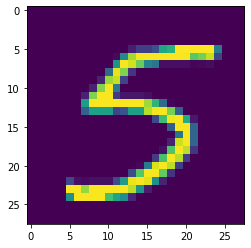

In [3]:
import matplotlib.pyplot as plt
plt.imshow(x_train[0].reshape(28,28))

In [4]:
y_train.shape

torch.Size([60000])

In [5]:
x_train_mini = x_train[:2000]
y_train_mini = y_train[:2000]
dataset_train_mini = torch.utils.data.TensorDataset(x_train, y_train)
model = Model(use_densenet=False, num_epochs=1)
torch.autograd.set_detect_anomaly(True)

Using a BayesNet model
initialising bayesian layer of size 784 x 100
initialising bayesian layer of size 100 x 100
initialising bayesian layer of size 100 x 10


In [6]:
# model.train(dataset_train_mini)

In [7]:
bl = model.network.layers[0]
print(bl)

BayesianLayer(
  (weights_prior): MultivariateDiagonalGaussian()
  (bias_prior): MultivariateDiagonalGaussian()
  (weights_var_posterior): MultivariateDiagonalGaussian()
  (bias_var_posterior): MultivariateDiagonalGaussian()
)


In [8]:

batch_x = x_train[:3]
batch_y = y_train[:3]

# out, log_prior, log_var_ptior = bl.forward(x_batch)
optimizer = torch.optim.Adam(model.network.parameters(), lr=1e-3)
model.network.train()


BayesNet(
  (layers): ModuleList(
    (0): BayesianLayer(
      (weights_prior): MultivariateDiagonalGaussian()
      (bias_prior): MultivariateDiagonalGaussian()
      (weights_var_posterior): MultivariateDiagonalGaussian()
      (bias_var_posterior): MultivariateDiagonalGaussian()
    )
    (1): BayesianLayer(
      (weights_prior): MultivariateDiagonalGaussian()
      (bias_prior): MultivariateDiagonalGaussian()
      (weights_var_posterior): MultivariateDiagonalGaussian()
      (bias_var_posterior): MultivariateDiagonalGaussian()
    )
    (2): BayesianLayer(
      (weights_prior): MultivariateDiagonalGaussian()
      (bias_prior): MultivariateDiagonalGaussian()
      (weights_var_posterior): MultivariateDiagonalGaussian()
      (bias_var_posterior): MultivariateDiagonalGaussian()
    )
  )
  (activation): ReLU()
)

In [10]:
model.network.zero_grad()

out, log_prior, log_var_ptior = model.network.forward(batch_x)
f = out, log_prior, log_var_ptior

class_predicted_probs = F.softmax(f[0], dim=1)
data_predicted_probs = torch.sum(class_predicted_probs * F.one_hot(batch_y, num_classes=10), dim=1)
eps=1e-5
data_predicted_probs = torch.max(data_predicted_probs, torch.tensor(eps).expand_as(data_predicted_probs))
num_not_maxed = torch.sum(data_predicted_probs > eps)
log_prob_of_data_given_network = torch.sum(
    torch.log( data_predicted_probs)
)
# loss = pi_i * (torch.sum(f[2]) - torch.sum(f[1])) - log_prob_of_data_given_network
loss = (torch.sum(f[2]) - torch.sum(f[1])) - log_prob_of_data_given_network

In [11]:
# loss.backward(retain_graph=True)
loss.backward()

In [12]:
optimizer.step()

In [13]:

batch_x = x_train[3:6]
batch_y = y_train[3:6]


optimizer.zero_grad()

out, log_prior, log_var_ptior = model.network.forward(batch_x)
f = out, log_prior, log_var_ptior

class_predicted_probs = F.softmax(f[0], dim=1)
data_predicted_probs = torch.sum(class_predicted_probs * F.one_hot(batch_y, num_classes=10), dim=1)
eps=1e-5
data_predicted_probs = torch.max(data_predicted_probs, torch.tensor(eps).expand_as(data_predicted_probs))
num_not_maxed = torch.sum(data_predicted_probs > eps)
log_prob_of_data_given_network = torch.sum(
    torch.log( data_predicted_probs)
)
# loss = pi_i * (torch.sum(f[2]) - torch.sum(f[1])) - log_prob_of_data_given_network
loss = (torch.sum(f[2]) - torch.sum(f[1])) - log_prob_of_data_given_network


In [14]:
loss.backward()

C:\Users\benja\Anaconda3\lib\site-packages\torch\autograd\__init__.py:149: UserWarning: Error detected in SoftplusBackward. Traceback of forward call that caused the error:
  File "C:\Users\benja\Anaconda3\lib\runpy.py", line 193, in _run_module_as_main
    "__main__", mod_spec)
  File "C:\Users\benja\Anaconda3\lib\runpy.py", line 85, in _run_code
    exec(code, run_globals)
  File "C:\Users\benja\Anaconda3\lib\site-packages\ipykernel_launcher.py", line 16, in <module>
    app.launch_new_instance()
  File "C:\Users\benja\Anaconda3\lib\site-packages\traitlets\config\application.py", line 658, in launch_instance
    app.start()
  File "C:\Users\benja\Anaconda3\lib\site-packages\ipykernel\kernelapp.py", line 505, in start
    self.io_loop.start()
  File "C:\Users\benja\Anaconda3\lib\site-packages\tornado\platform\asyncio.py", line 148, in start
    self.asyncio_loop.run_forever()
  File "C:\Users\benja\Anaconda3\lib\asyncio\base_events.py", line 539, in run_forever
    self._run_once()
  

RuntimeError: Trying to backward through the graph a second time (or directly access saved variables after they have already been freed). Saved intermediate values of the graph are freed when you call .backward() or autograd.grad(). Specify retain_graph=True if you need to backward through the graph a second time or if you need to access saved variables after calling backward.

In [ ]:
optimizer.step()

In [23]:
bl.weights_var_posterior.mu.grad

tensor([ 0.5452,  0.7160, -0.5759,  ..., -1.4657,  0.2981,  0.6082])

In [22]:
model.network.layers[0].weights_var_posterior.mu

Parameter containing:
tensor([0., 0., 0.,  ..., 0., 0., 0.], requires_grad=True)